In [1]:
import time
import numpy as np
import scipy.special
import jax.numpy as jnp
import matplotlib.pyplot as plt
# import optimizer_traj_opt

from jax import jit, jacfwd, jacrev, random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
def bernstein_coeff_order10_new(n, tmin, tmax, t_actual):
    l = tmax - tmin
    t = (t_actual - tmin) / l

    P0 = scipy.special.binom(n, 0) * ((1 - t) ** (n - 0)) * t ** 0
    P1 = scipy.special.binom(n, 1) * ((1 - t) ** (n - 1)) * t ** 1
    P2 = scipy.special.binom(n, 2) * ((1 - t) ** (n - 2)) * t ** 2
    P3 = scipy.special.binom(n, 3) * ((1 - t) ** (n - 3)) * t ** 3
    P4 = scipy.special.binom(n, 4) * ((1 - t) ** (n - 4)) * t ** 4
    P5 = scipy.special.binom(n, 5) * ((1 - t) ** (n - 5)) * t ** 5
    P6 = scipy.special.binom(n, 6) * ((1 - t) ** (n - 6)) * t ** 6
    P7 = scipy.special.binom(n, 7) * ((1 - t) ** (n - 7)) * t ** 7
    P8 = scipy.special.binom(n, 8) * ((1 - t) ** (n - 8)) * t ** 8
    P9 = scipy.special.binom(n, 9) * ((1 - t) ** (n - 9)) * t ** 9
    P10 = scipy.special.binom(n, 10) * ((1 - t) ** (n - 10)) * t ** 10

    P0dot = -10.0 * (-t + 1) ** 9
    P1dot = -90.0 * t * (-t + 1) ** 8 + 10.0 * (-t + 1) ** 9
    P2dot = -360.0 * t ** 2 * (-t + 1) ** 7 + 90.0 * t * (-t + 1) ** 8
    P3dot = -840.0 * t ** 3 * (-t + 1) ** 6 + 360.0 * t ** 2 * (-t + 1) ** 7
    P4dot = -1260.0 * t ** 4 * (-t + 1) ** 5 + 840.0 * t ** 3 * (-t + 1) ** 6
    P5dot = -1260.0 * t ** 5 * (-t + 1) ** 4 + 1260.0 * t ** 4 * (-t + 1) ** 5
    P6dot = -840.0 * t ** 6 * (-t + 1) ** 3 + 1260.0 * t ** 5 * (-t + 1) ** 4
    P7dot = -360.0 * t ** 7 * (-t + 1) ** 2 + 840.0 * t ** 6 * (-t + 1) ** 3
    P8dot = 45.0 * t ** 8 * (2 * t - 2) + 360.0 * t ** 7 * (-t + 1) ** 2
    P9dot = -10.0 * t ** 9 + 9 * t ** 8 * (-10.0 * t + 10.0)
    P10dot = 10.0 * t ** 9

    P0ddot = 90.0 * (-t + 1) ** 8
    P1ddot = 720.0 * t * (-t + 1) ** 7 - 180.0 * (-t + 1) ** 8
    P2ddot = 2520.0 * t ** 2 * (-t + 1) ** 6 - 1440.0 * t * (-t + 1) ** 7 + 90.0 * (-t + 1) ** 8
    P3ddot = 5040.0 * t ** 3 * (-t + 1) ** 5 - 5040.0 * t ** 2 * (-t + 1) ** 6 + 720.0 * t * (-t + 1) ** 7
    P4ddot = 6300.0 * t ** 4 * (-t + 1) ** 4 - 10080.0 * t ** 3 * (-t + 1) ** 5 + 2520.0 * t ** 2 * (-t + 1) ** 6
    P5ddot = 5040.0 * t ** 5 * (-t + 1) ** 3 - 12600.0 * t ** 4 * (-t + 1) ** 4 + 5040.0 * t ** 3 * (-t + 1) ** 5
    P6ddot = 2520.0 * t ** 6 * (-t + 1) ** 2 - 10080.0 * t ** 5 * (-t + 1) ** 3 + 6300.0 * t ** 4 * (-t + 1) ** 4
    P7ddot = -360.0 * t ** 7 * (2 * t - 2) - 5040.0 * t ** 6 * (-t + 1) ** 2 + 5040.0 * t ** 5 * (-t + 1) ** 3
    P8ddot = 90.0 * t ** 8 + 720.0 * t ** 7 * (2 * t - 2) + 2520.0 * t ** 6 * (-t + 1) ** 2
    P9ddot = -180.0 * t ** 8 + 72 * t ** 7 * (-10.0 * t + 10.0)
    P10ddot = 90.0 * t ** 8

    P = np.hstack((P0, P1, P2, P3, P4, P5, P6, P7, P8, P9, P10))
    Pdot = np.hstack((P0dot, P1dot, P2dot, P3dot, P4dot, P5dot, P6dot, P7dot, P8dot, P9dot, P10dot)) / l
    Pddot = np.hstack((P0ddot, P1ddot, P2ddot, P3ddot, P4ddot, P5ddot, P6ddot, P7ddot, P8ddot, P9ddot, P10ddot)) / (l ** 2)
    return P, Pdot, Pddot

In [13]:
import matplotlib.pyplot as plt

def plot(traj, obs, cnt = 0, draw = True):
    plt.xlim([np.amin(traj["x"])-1, np.amax(traj["x"])+1])    
    plt.ylim([np.amin(traj["y"])-1, np.amax(traj["y"])+1])    
    plt.scatter(traj["x"], traj["y"], label="Trajectory")    
    plt.scatter(obs["x"], obs["y"], s=200, label="Obstacles")
    plt.legend()
    plt.savefig("tests/{}.png".format(cnt))
    plt.clf()
    if draw:
        plt.show()

In [5]:
import cvxopt
from cvxopt import solvers
def compute_sol_qp(rho_obs, rho_eq, weight_smoothness, num_obs, bx_eq, by_eq, P, Pdot, Pddot, x_obs, y_obs, a_obs, b_obs):
    maxiter = 2
    nvar = np.shape(P)[1]
    num = np.shape(P)[0]

#     print(P.shape)
#     print(Pdot.shape)
#     print(Pddot.shape)
    
    A_eq = np.vstack((P[0], Pdot[0], Pddot[0], P[-1], Pdot[-1], Pddot[-1]))
    A_obs = np.tile(P, (num_obs, 1))

    cost_smoothness = weight_smoothness * np.dot(Pddot.T, Pddot)

    alpha_obs = np.zeros((num_obs, num))
    d_obs = np.ones((num_obs, num))

    lamda_x = np.zeros(nvar)
    lamda_y = np.zeros(nvar)
    res_obs = np.ones(maxiter)
    res_eq = np.ones(maxiter)
    d_min = np.ones(maxiter)
    b_x_obs = x_obs.reshape(num_obs * num)
    b_y_obs = y_obs.reshape(num_obs * num)    
    cost = cost_smoothness + rho_obs * np.dot(A_obs.T, A_obs) + rho_eq * np.dot(A_eq.T, A_eq)
    for i in range(0, maxiter):
        temp_x_obs = d_obs * np.cos(alpha_obs) * a_obs
#         print("temp_x_obs.shape: {}, x_obs.shape: {} ".format(temp_x_obs.shape, x_obs.shape))
        b_obs_x = x_obs.reshape(num * num_obs) + temp_x_obs.reshape(num * num_obs)
#         print("x_obs.shape: {}, b_obs_x.shape: {}".format(x_obs.shape, b_obs_x.shape))

        temp_y_obs = d_obs * np.sin(alpha_obs) * b_obs
        b_obs_y = y_obs.reshape(num * num_obs) + temp_y_obs.reshape(num*num_obs)

        bb_obs = np.hstack((x_obs,y_obs))
        A_eq = np.vstack((P[0], Pdot[0], Pddot[0], P[-1], Pdot[-1], Pddot[-1]))

        A_obs = np.tile(P, (num_obs, 1))
        b_eq = np.hstack((bx_eq, by_eq))

        Q_obs = np.dot(A_obs.T, A_obs)
        Q_eq = np.dot(A_eq.T, A_eq)
        qx_obs = np.dot(b_x_obs.T, A_obs) * 2
        qy_obs = np.dot(b_y_obs.T, A_obs) * 2
        qx_eq = np.dot(bx_eq.T, A_eq) * 2
        qy_eq = np.dot(by_eq.T, A_eq) * 2
        q = np.hstack((qx_eq, qy_eq))
        print(qx_obs.shape)
        A_eq = cvxopt.matrix(A_eq, tc='d')
        bx_eq_m = cvxopt.matrix(bx_eq, tc='d')
        by_eq_m = cvxopt.matrix(by_eq, tc='d')
        b_eq = cvxopt.matrix(b_eq, tc='d')
        Q = cvxopt.matrix(weight_smoothness * Q_smoothness_new + rho_obs * Q_obs + rho_eq * Q_eq, tc='d')
        q_x = cvxopt.matrix(rho_obs * qx_obs + rho_eq * qx_eq, tc='d')
        q_y = cvxopt.matrix(rho_obs * qy_obs + rho_eq * qy_eq, tc='d')
        
        print(q_x.size)
        print(bx_eq.shape)
        sol_x = solvers.qp(Q, q_x, None, None, A_eq, bx_eq_m)
        sol_x = np.array(sol_x['x'])
        sol_y = solvers.qp(Q, q_y, None, None, A_eq, by_eq_m)
        sol_y = np.array(sol_y['x'])
        x = np.dot(P, sol_x)#.reshape(num)
        y = np.dot(P, sol_y)#.reshape(num)

        print("x.shape: {}, y.shape: {}".format(x.shape, y.shape))

#         wc_alpha = (x - x_obs)
#         ws_alpha = (y - y_obs)
        x = x.reshape((num, 1))
        y = y.reshape((num, 1))
# #         print("wc_alpha.shape: {}, ws_alpha.shape: {}".format(wc_alpha.shape, ws_alpha.shape))
#         alpha_obs = np.arctan2(ws_alpha * a_obs, wc_alpha * b_obs)
        
#         c1_d = 1.0 * rho_obs * (a_obs ** 2 * np.cos(alpha_obs) ** 2 + b_obs ** 2 * np.sin(alpha_obs) ** 2)
#         c2_d = 1.0 * rho_obs * (a_obs * wc_alpha * np.cos(alpha_obs) + b_obs * ws_alpha * np.sin(alpha_obs))

#         d_temp = c2_d / c1_d
#         d_obs = np.maximum(np.ones((num_obs, num)), d_temp)
#         d_min[i] = np.amin(d_temp)

#         res_x_obs_vec = wc_alpha - a_obs * d_obs * np.cos(alpha_obs)
#         res_y_obs_vec = ws_alpha - b_obs * d_obs * np.sin(alpha_obs)
        
#         res_eq_x_vec = np.dot(A_eq, sol_x) - bx_eq
#         res_eq_y_vec = np.dot(A_eq, sol_y) - by_eq
    

    return x.squeeze(),y.squeeze()

In [37]:
def compute_sol(rho_obs, rho_eq, weight_smoothness, num_obs, bx_eq, by_eq, P, Pdot, Pddot, x_obs, y_obs, A_obs, A_eq, a_obs=1, b_obs=1):    
    maxiter = 300
    nvar = np.shape(P)[1]
    num = np.shape(P)[0]

    A_eq = np.vstack((P[0], Pdot[0], Pddot[0], P[-1], Pdot[-1], Pddot[-1]))
    A_obs = np.tile(P, (num_obs, 1))

    cost_smoothness = weight_smoothness * np.dot(Pddot.T, Pddot)

    alpha_obs = np.zeros((num_obs, num))
    d_obs = np.ones((num_obs, num))

    lamda_x = np.zeros(nvar)
    lamda_y = np.zeros(nvar)
    res_obs = np.ones(maxiter)
    res_eq = np.ones(maxiter)
    d_min = np.ones(maxiter)

    cost = cost_smoothness + rho_obs * np.dot(A_obs.T, A_obs) + rho_eq * np.dot(A_eq.T, A_eq)

    
    for i in range(0, maxiter):
        temp_x_obs = d_obs * np.cos(alpha_obs) * a_obs
#         print("temp_x_obs.shape: {}, x_obs.shape: {} ".format(temp_x_obs.shape, x_obs.shape))
        b_obs_x = x_obs.reshape(num * num_obs) + temp_x_obs.reshape(num * num_obs)
#         print("x_obs.shape: {}, b_obs_x.shape: {}".format(x_obs.shape, b_obs_x.shape))

        temp_y_obs = d_obs * np.sin(alpha_obs) * b_obs
        b_obs_y = y_obs.reshape(num * num_obs) + temp_y_obs.reshape(num*num_obs)

        lincost_x = -lamda_x - rho_obs * np.dot(A_obs.T, b_obs_x) - rho_eq * np.dot(A_eq.T, bx_eq)
        lincost_y = -lamda_y - rho_obs * np.dot(A_obs.T, b_obs_y) - rho_eq * np.dot(A_eq.T, by_eq)

        sol_x = np.linalg.solve(-cost, lincost_x)
        sol_y = np.linalg.solve(-cost, lincost_y)
        
#         print("sol_x.shape: {}, sol_y.shape: {}".format(sol_x.shape, sol_y.shape))

        x = np.dot(P, sol_x)
        y = np.dot(P, sol_y)
        
#         print("x.shape: {}, y.shape: {}".format(x.shape, y.shape))

        wc_alpha = (x - x_obs)
        ws_alpha = (y - y_obs)
#         print("wc_alpha.shape: {}, ws_alpha.shape: {}".format(wc_alpha.shape, ws_alpha.shape))
        alpha_obs = np.arctan2(ws_alpha * a_obs, wc_alpha * b_obs)
        
        c1_d = 1.0 * rho_obs * (a_obs ** 2 * np.cos(alpha_obs) ** 2 + b_obs ** 2 * np.sin(alpha_obs) ** 2)
        c2_d = 1.0 * rho_obs * (a_obs * wc_alpha * np.cos(alpha_obs) + b_obs * ws_alpha * np.sin(alpha_obs))

        d_temp = c2_d / c1_d
        d_obs = np.maximum(np.ones((num_obs, num)), d_temp)
        d_min[i] = np.amin(d_temp)

        res_x_obs_vec = wc_alpha - a_obs * d_obs * np.cos(alpha_obs)
        res_y_obs_vec = ws_alpha - b_obs * d_obs * np.sin(alpha_obs)
        
        res_eq_x_vec = np.dot(A_eq, sol_x) - bx_eq
        res_eq_y_vec = np.dot(A_eq, sol_y) - by_eq

#         print("update : {},lamda_x: {}".format((rho_obs*np.dot(A_obs.T, res_x_obs_vec.reshape(num_obs * num)) - rho_eq * np.dot(A_eq.T, res_eq_x_vec)).shape, lamda_x.shape))
#         print("update : {}".format(rho_obs*np.dot(A_obs.T, res_y_obs_vec.reshape(num_obs * num)) - rho_eq * np.dot(A_eq.T, res_eq_y_vec).shape, lamda_y.shape))
        lamda_x = lamda_x-rho_obs*np.dot(A_obs.T, res_x_obs_vec.reshape(num_obs * num)) - rho_eq * np.dot(A_eq.T, res_eq_x_vec)
        lamda_y = lamda_y-rho_obs*np.dot(A_obs.T, res_y_obs_vec.reshape(num_obs * num)) - rho_eq * np.dot(A_eq.T, res_eq_y_vec)

        res_eq[i] = np.linalg.norm(np.hstack((res_eq_x_vec,  res_eq_y_vec)))
        res_obs[i] = np.linalg.norm(np.hstack((res_x_obs_vec, res_y_obs_vec)))

    slack_obs = np.sqrt((d_obs - 1))
#     plt.figure(1)
#     plt.plot(res_obs)
#     plt.figure(2)
#     plt.plot(res_eq)
#     plt.figure(3)
#     plt.plot(d_min)    
#     plt.show()
    return x, y, sol_x, sol_y, alpha_obs.reshape(num_obs*num), d_obs.reshape(num_obs*num), lamda_x, lamda_y, slack_obs.reshape(num_obs*num)

In [7]:
def cost_fun_qp(aug_sol_jax, param_sol):
    x_init, vx_init, ax_init, x_fin, vx_fin, ax_fin, y_init, vy_init, ay_init, y_fin, vy_fin, ay_fin = param_sol

    bx_eq_jax =  jnp.hstack((x_init, vx_init, ax_init, x_fin, vx_fin, ax_fin))
    by_eq_jax =  jnp.hstack((y_init, vy_init, ay_init, y_fin, vy_fin, ay_fin))

    c_x = aug_sol_jax[0:nvar]
    c_y = aug_sol_jax[nvar:2*nvar]

    num_tot = num_obs * num

    alpha_obs = aug_sol_jax[2*nvar:2*nvar+num_tot]
    d_obs = aug_sol_jax[2*nvar+num_tot:2*nvar+2*num_tot]

    cost_smoothness_x = 0.5 * weight_smoothness * jnp.dot(c_x.T, jnp.dot(Q_smoothness_jax, c_x))
    cost_smoothness_y = 0.5 * weight_smoothness * jnp.dot(c_y.T, jnp.dot(Q_smoothness_jax, c_y))

    temp_x_obs = d_obs * jnp.cos(alpha_obs) * a_obs
    b_obs_x = x_obs_jax.reshape(num * num_obs) + temp_x_obs

    temp_y_obs = d_obs * jnp.sin(alpha_obs) * b_obs
    b_obs_y = y_obs_jax.reshape(num * num_obs) + temp_y_obs

    cost_obs_x = 0.5 * rho_obs * (jnp.sum((jnp.dot(A_obs_jax, c_x) - b_obs_x) ** 2))
    cost_obs_y = 0.5 * rho_obs * (jnp.sum((jnp.dot(A_obs_jax, c_y) - b_obs_y) ** 2))
    
    cost_slack = rho_obs * jnp.sum(jnp.maximum(jnp.zeros(num_tot), -d_obs + 1))
    cost_eq_x = 0.5 * rho_eq * (jnp.sum((jnp.dot(A_eq_jax, c_x) - bx_eq_jax) ** 2))
    cost_eq_y = 0.5 * rho_eq * (jnp.sum((jnp.dot(A_eq_jax, c_y) - by_eq_jax) ** 2))
    
    cost_x = cost_smoothness_x + cost_obs_x + cost_eq_x - jnp.dot(lamda_x_jax.T, c_x)
    cost_y = cost_smoothness_y + cost_obs_y + cost_eq_y - jnp.dot(lamda_y_jax.T, c_y)
   
    eps = 10 ** (-8.0)
    cost = cost_x + cost_y + eps * jnp.sum(c_x ** 2) + eps * jnp.sum(c_y ** 2) + eps * jnp.sum(d_obs ** 2) + eps * jnp.sum(alpha_obs ** 2) + cost_slack
    return cost

In [8]:
def cost_fun(aug_sol_jax, param_sol, a_obs, b_obs, A_obs_jax, b_obs_jax, A_eq_jax, bx_eq_jax, by_eq_jax, num_obs = 4, num = 20):
    x_init, vx_init, ax_init, x_fin, vx_fin, ax_fin, y_init, vy_init, ay_init, y_fin, vy_fin, ay_fin = param_sol

    bx_eq_jax =  jnp.hstack((x_init, vx_init, ax_init, x_fin, vx_fin, ax_fin))
    by_eq_jax =  jnp.hstack((y_init, vy_init, ay_init, y_fin, vy_fin, ay_fin))

    c_x = aug_sol_jax[0:nvar]
    c_y = aug_sol_jax[nvar:2*nvar]

    num_tot = num_obs * num

    alpha_obs = aug_sol_jax[2*nvar:2*nvar+num_tot]
    d_obs = aug_sol_jax[2*nvar+num_tot:2*nvar+2*num_tot]

    cost_smoothness_x = 0.5 * weight_smoothness * jnp.dot(c_x.T, jnp.dot(Q_smoothness_jax, c_x))
    cost_smoothness_y = 0.5 * weight_smoothness * jnp.dot(c_y.T, jnp.dot(Q_smoothness_jax, c_y))

    temp_x_obs = d_obs * jnp.cos(alpha_obs) * a_obs
    b_obs_x = x_obs_jax.reshape(num * num_obs) + temp_x_obs

    temp_y_obs = d_obs * jnp.sin(alpha_obs) * b_obs
    b_obs_y = y_obs_jax.reshape(num * num_obs) + temp_y_obs

    cost_obs_x = 0.5 * rho_obs * (jnp.sum((jnp.dot(A_obs_jax, c_x) - b_obs_x) ** 2))
    cost_obs_y = 0.5 * rho_obs * (jnp.sum((jnp.dot(A_obs_jax, c_y) - b_obs_y) ** 2))
    
    cost_slack = rho_obs * jnp.sum(jnp.maximum(jnp.zeros(num_tot), -d_obs + 1))
    cost_eq_x = 0.5 * rho_eq * (jnp.sum((jnp.dot(A_eq_jax, c_x) - bx_eq_jax) ** 2))
    cost_eq_y = 0.5 * rho_eq * (jnp.sum((jnp.dot(A_eq_jax, c_y) - by_eq_jax) ** 2))
    
    cost_x = cost_smoothness_x + cost_obs_x + cost_eq_x - jnp.dot(lamda_x_jax.T, c_x)
    cost_y = cost_smoothness_y + cost_obs_y + cost_eq_y - jnp.dot(lamda_y_jax.T, c_y)
   
    eps = 10 ** (-8.0)
    cost = cost_x + cost_y + eps * jnp.sum(c_x ** 2) + eps * jnp.sum(c_y ** 2) + eps * jnp.sum(d_obs ** 2) + eps * jnp.sum(alpha_obs ** 2) + cost_slack
    return cost

In [9]:
def generate(params, x_obs_temp, y_obs_temp, num = 20, cost_fun = cost_fun, compute_sol = compute_sol):
    x_min = -6.0
    x_max = 6.0

    y_min = -6.0
    y_max = 6.0

    t_fin = 8.0
    num = 20
    
    (x_init, y_init, vx_init, ax_init, vy_init, ay_init, x_fin, y_fin, vx_fin, ax_fin, vy_fin, ay_fin) = params
    
    tot_time = np.linspace(0.0, t_fin, num)
    tot_time_copy = tot_time.reshape(num, 1)
    P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
    nvar = np.shape(P)[1]
    num = np.shape(P)[0]

    num_obs = np.shape(x_obs_temp)[0]

    a_obs = 1.0
    b_obs = 1.0

    x_obs = np.ones((num_obs, num)) * x_obs_temp[:, np.newaxis]
    y_obs = np.ones((num_obs, num)) * y_obs_temp[:, np.newaxis]   
    
    rho_obs = 0.3
    rho_eq = 10.0
    weight_smoothness = 10    
    
    bx_eq =  np.hstack((x_init, vx_init, ax_init, x_fin, vx_fin, ax_fin))
    by_eq =  np.hstack((y_init, vy_init, ay_init, y_fin, vy_fin, ay_fin))
    
    A_eq = np.vstack((P[0], Pdot[0], Pddot[0], P[-1], Pdot[-1], Pddot[-1]))
    A_obs = np.tile(P, (num_obs, 1))
    Q_smoothness = np.dot(Pddot.T, Pddot)
    Q_smoothness_new = Q_smoothness
    
    P_jax = jnp.asarray(P)
    A_eq_jax = jnp.asarray(A_eq)
    A_obs_jax = jnp.asarray(A_obs)
    x_obs_jax = jnp.asarray(x_obs)
    y_obs_jax = jnp.asarray(y_obs)
    Q_smoothness_jax = jnp.asarray(Q_smoothness)
    
    x, y, sol_x, sol_y, alpha_obs, d_obs, lamda_x, lamda_y, slack_obs = compute_sol(rho_obs, rho_eq, weight_smoothness, num_obs, bx_eq, by_eq, P, Pdot, Pddot, x_obs, y_obs, a_obs, b_obs)
    
    return x,y

In [10]:
x_init = -2.87
y_init = 2.96
vx_init = 0.0
ax_init = 0.0
vy_init = 0.0
ay_init = 0.0    

x_fin = 1.4
y_fin = 0.2
vx_fin = 0.0
ax_fin = 0.0
vy_fin = 0.0
ay_fin = 0.0 

params = (x_init, y_init, vx_init, ax_init, vy_init, ay_init, x_fin, y_fin, vx_fin, ax_fin, vy_fin, ay_fin)

x_obs_temp = np.hstack((-2.0, -0.79, 3.0, 4.0))
y_obs_temp = np.hstack((-2.0, 1.0, -0.80, 2.0))
x,y = generate(params, x_obs_temp, y_obs_temp, compute_sol= compute_sol_qp)

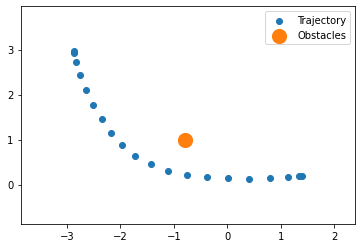

In [11]:
plot({"x":x, "y":y}, {"x":x_obs_temp, "y":y_obs_temp})

In [60]:
import random
arr = []
obs = []
for i in range(100):
    x_init = random.randrange(0,5)
    y_init = random.randrange(0,5)
    vx_init = 0.0
    ax_init = 0.0
    vy_init = 0.0
    ay_init = 0.0    

    x_fin = random.randrange(0,5)
    y_fin = random.randrange(0,5)
    vx_fin = 0.0
    ax_fin = 0.0
    vy_fin = 0.0
    ay_fin = 0.0
    
    params = (x_init, y_init, vx_init, ax_init, vy_init, ay_init, x_fin, y_fin, vx_fin, ax_fin, vy_fin, ay_fin)

    x_obs_temp = np.random.rand(1,4)
    y_obs_temp = np.random.rand(1,4)

    x_obs_temp = np.hstack((-2.0, 0.79, 3.0, 4.0))
    y_obs_temp = np.hstack((-2.0, 5.0, -0.80, 2.0))
    x,y = generate(params, x_obs_temp, y_obs_temp, compute_sol = compute_sol_qp) 
#     arr.append([x,y])
    obs.append([x_obs_temp, y_obs_temp])
    barr = np.array([x,y]).T
    arr.append(barr.T)
    
    plot({"x":x, "y":y}, {"x":x_obs_temp, "y":y_obs_temp}, cnt = i, draw = False)   

<Figure size 432x288 with 0 Axes>

In [61]:
print(np.array(arr).shape)

(100, 2, 20)


In [62]:
print(np.array(arr[0]).shape)

(2, 20)


In [63]:
print(np.array(obs).shape)

(100, 2, 4)


In [64]:
np.save("./train/test.npy", arr)

In [65]:
np.save("./train/obstacle.npy", obs)

In [66]:
x_obs_temp = np.hstack((-2.0, -0.79, 3.0, 4.0))
y_obs_temp = np.hstack((-2.0, 1.0, -0.80, 2.0))
print(x_obs_temp.shape)

(4,)
